In this notebook I am going to create classification model using XGBoostClassifier to train the model for predicting whether the customers has accepted promotions or not. I will use SHAP to analyze the model's performance. I have taken Marketing campaign dataset from kaggle.

Let's start with importing relevant libraries.

In [1]:
import pandas as pd
import numpy as np
import os

In [2]:
data= pd.read_csv("Marketing_campaign.csv", sep= "\t")
data.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

We have 2240 observations. This comprises of 29 features.

Before starting data analysis journey let's check data dictionary first. This will give a overview of coulumns present in our dataset. 
Important features to understand here are:

Recency- it represent the no of days after customer's last purchase 

Mnt- this word speaks about amount spent on items

Num- this dipicts numbers of purchase

Accepted Cmp- gives no of coupons taken by the customers

Details over Zcost and ZRevenue columns are not provided in data dictionary.

Let's first of all see what all features contain categorical variables.

In [4]:
categorical_cols= [x for x in data.dtypes.index if data.dtypes[x]=='object']
categorical_cols

['Education', 'Marital_Status', 'Dt_Customer']

In [5]:
data['Dt_Customer'] = pd.to_datetime(data['Dt_Customer']) # this column contains date as data. So it must be in date-time format.

In [6]:
data.Education.unique()

array(['Graduation', 'PhD', 'Master', 'Basic', '2n Cycle'], dtype=object)

In [7]:
data.Marital_Status.unique()

array(['Single', 'Together', 'Married', 'Divorced', 'Widow', 'Alone',
       'Absurd', 'YOLO'], dtype=object)

In Marital_Status column there is possibility to group categories and hence organise it to get more meningful insight.

Hence let's provide numbers to categories.

Also in education column we need to convert categories in numbers.

We can use LabelEncoder or one-hot encoding also.

In [8]:
mapping_marital_status = {'Single' : 0, 'Together': 1, 'Married': 1, 'Divorced': 0, 'Widow': 0, 'Alone': 0,
       'Absurd': 0, 'YOLO': 0}
mapping_education= {'Graduation': 1, 'PhD': 2, 'Master': 2, 'Basic': 0, '2n Cycle': 2}
data=data.replace({'Marital_Status': mapping_marital_status, 'Education': mapping_education}) 


In [9]:
data.isnull().sum().sort_values(ascending=False)/data.shape[0]*100  # checking missing values

Income                 1.071429
Response               0.000000
MntSweetProducts       0.000000
Year_Birth             0.000000
Education              0.000000
Marital_Status         0.000000
Kidhome                0.000000
Teenhome               0.000000
Dt_Customer            0.000000
Recency                0.000000
MntWines               0.000000
MntFruits              0.000000
MntMeatProducts        0.000000
MntFishProducts        0.000000
MntGoldProds           0.000000
Z_Revenue              0.000000
NumDealsPurchases      0.000000
NumWebPurchases        0.000000
NumCatalogPurchases    0.000000
NumStorePurchases      0.000000
NumWebVisitsMonth      0.000000
AcceptedCmp3           0.000000
AcceptedCmp4           0.000000
AcceptedCmp5           0.000000
AcceptedCmp1           0.000000
AcceptedCmp2           0.000000
Complain               0.000000
Z_CostContact          0.000000
ID                     0.000000
dtype: float64

In [10]:
#We have very less %age of data missing. Hence we can drop these observations easily.

data=data.dropna()

In [11]:
data['Income']= data.Income.round(0).astype('int')  # changing dtype of Income feature from float to integer

In this dataset we have few columns simmilar to others. We can group them together. This will reduce features and may provide better visualizations.

We will apply some feature engineering techniques also on this dataset.

In [12]:
data['Kidhome'].unique()

array([0, 1, 2], dtype=int64)

In [13]:
data.Teenhome.unique()

array([0, 1, 2], dtype=int64)

In [14]:
data['kid_teen'] = data['Kidhome'] + data['Teenhome']
data['kid_teen']= np.where(data['kid_teen'] > 0, 1, 0)
data.kid_teen

0       0
1       1
2       0
3       1
4       1
       ..
2235    1
2236    1
2237    0
2238    1
2239    1
Name: kid_teen, Length: 2216, dtype: int32

In [15]:
data['current_year'] = 2021
data['age'] = data['current_year']-data['Year_Birth']

In [16]:
data['current_date'] = '01-01-2015'
data['current_date'] = pd.to_datetime(data.current_date)
data['days_customer'] = (data['current_date']-data['Dt_Customer']).dt.days

In [17]:
data['luxurious_item'] = data['MntWines']+ data['MntSweetProducts']+ data['MntGoldProds']
data['food'] = data['MntFishProducts'] + data['MntFruits'] + data['MntMeatProducts'] + data['MntSweetProducts']


In [18]:
data['accepted_cmp']= data['AcceptedCmp1']+data['AcceptedCmp2']+data['AcceptedCmp3']+data['AcceptedCmp4']+data['AcceptedCmp5']+data['Response']
data['accepted_cmp']= np.where(data['accepted_cmp'] > 0, 1, 0)

In [19]:
data.Response.value_counts()

0    1883
1     333
Name: Response, dtype: int64

This dataset is highly imbalanced but we have sufficient observation to train our model. If the model shows overfitting problem then i wll apply SMOTE techniques.

In [20]:
data.corr()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,...,Z_CostContact,Z_Revenue,Response,kid_teen,current_year,age,days_customer,luxurious_item,food,accepted_cmp
ID,1.000000,0.002355,-0.016106,0.017921,0.013095,0.001736,-0.003030,-0.044376,-0.021084,0.007326,...,NaN,NaN,-0.021491,0.000225,NaN,-0.002355,-0.006275,-0.020893,-0.008299,-0.033103
Year_Birth,0.002355,1.000000,-0.127629,0.002033,-0.161791,0.233615,-0.350791,-0.016295,-0.159451,-0.017747,...,NaN,NaN,0.023692,0.012448,NaN,-1.000000,0.026243,-0.152575,-0.036234,-0.032658
Education,-0.016106,-0.127629,1.000000,0.013619,0.096288,-0.029750,0.090906,-0.025980,0.134135,-0.070492,...,NaN,NaN,0.064834,0.008014,NaN,0.127629,-0.043908,0.100891,-0.023660,0.044999
Marital_Status,0.017921,0.002033,0.013619,1.000000,0.004663,0.026788,0.031651,-0.001371,-0.007244,-0.025988,...,NaN,NaN,-0.150161,0.057379,NaN,-0.002033,0.003027,-0.011630,-0.025325,-0.064386
Income,0.013095,-0.161791,0.096288,0.004663,1.000000,-0.428669,0.019133,-0.003970,0.578650,0.430842,...,NaN,NaN,0.133047,-0.338153,NaN,0.161791,-0.016712,0.606110,0.610154,0.231499
Kidhome,0.001736,0.233615,-0.029750,0.026788,-0.428669,1.000000,-0.039869,0.011492,-0.497336,-0.373396,...,NaN,NaN,-0.077909,0.520454,NaN,-0.233615,-0.056877,-0.531073,-0.481318,-0.166590
Teenhome,-0.003030,-0.350791,0.090906,0.031651,0.019133,-0.039869,1.000000,0.013838,0.003747,-0.176558,...,NaN,NaN,-0.153901,0.587441,NaN,0.350791,0.008422,-0.017020,-0.267666,-0.128046
Recency,-0.044376,-0.016295,-0.025980,-0.001371,-0.003970,0.011492,0.013838,1.000000,0.015721,-0.005844,...,NaN,NaN,-0.199766,0.002485,NaN,0.016295,0.030777,0.019089,0.018841,-0.102253
MntWines,-0.021084,-0.159451,0.134135,-0.007244,0.578650,-0.497336,0.003747,0.015721,1.000000,0.387024,...,NaN,NaN,0.246299,-0.343094,NaN,0.159451,0.148720,0.984031,0.579373,0.422374
MntFruits,0.007326,-0.017747,-0.070492,-0.025988,0.430842,-0.373396,-0.176558,-0.005844,0.387024,1.000000,...,NaN,NaN,0.122443,-0.411963,NaN,0.017747,0.059609,0.459682,0.700620,0.142539


selecting features to be used to train and build the best model.

In [21]:
new_data= data[["age","Education","Marital_Status","Income", "Recency","luxurious_item","food",
               "NumDealsPurchases", "NumWebPurchases", "NumCatalogPurchases","NumWebVisitsMonth","accepted_cmp","Complain", "kid_teen","Response"]]

In [22]:
new_data_1= new_data.copy()

In [23]:
new_data_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2216 entries, 0 to 2239
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   age                  2216 non-null   int64
 1   Education            2216 non-null   int64
 2   Marital_Status       2216 non-null   int64
 3   Income               2216 non-null   int32
 4   Recency              2216 non-null   int64
 5   luxurious_item       2216 non-null   int64
 6   food                 2216 non-null   int64
 7   NumDealsPurchases    2216 non-null   int64
 8   NumWebPurchases      2216 non-null   int64
 9   NumCatalogPurchases  2216 non-null   int64
 10  NumWebVisitsMonth    2216 non-null   int64
 11  accepted_cmp         2216 non-null   int32
 12  Complain             2216 non-null   int64
 13  kid_teen             2216 non-null   int32
 14  Response             2216 non-null   int64
dtypes: int32(3), int64(12)
memory usage: 251.0 KB


In [24]:
new_data_1= new_data_1.astype('int64')

In [25]:
new_data_1.dtypes

age                    int64
Education              int64
Marital_Status         int64
Income                 int64
Recency                int64
luxurious_item         int64
food                   int64
NumDealsPurchases      int64
NumWebPurchases        int64
NumCatalogPurchases    int64
NumWebVisitsMonth      int64
accepted_cmp           int64
Complain               int64
kid_teen               int64
Response               int64
dtype: object

In [26]:
new_data.describe().T

,count,mean,std,min,25%,50%,75%,max
age,2216.0,52.179603,11.985554,25.0,44.0,51.0,62.0,128.0
Education,2216.0,1.447653,0.544178,0.0,1.0,1.0,2.0,2.0
Marital_Status,2216.0,0.645307,0.478528,0.0,0.0,1.0,1.0,1.0
Income,2216.0,52247.251354,25173.076661,1730.0,35303.0,51381.5,68522.0,666666.0
Recency,2216.0,49.012635,28.948352,0.0,24.0,49.0,74.0,99.0
luxurious_item,2216.0,376.085740,379.773555,3.0,41.0,246.0,617.0,1689.0
food,2216.0,258.018502,312.051990,1.0,29.0,101.0,419.0,1728.0
NumDealsPurchases,2216.0,2.323556,1.923716,0.0,1.0,2.0,3.0,15.0
NumWebPurchases,2216.0,4.085289,2.740951,0.0,2.0,4.0,6.0,27.0
NumCatalogPurchases,2216.0,2.671029,2.926734,0.0,0.0,2.0,4.0,28.0


You can see that all our selected features are measured on different scales. We must normalize them and make them comparable on same scale. Therefore we will use both normalization and StandardScaler from sklearn libraries to train the model and see with which parameter the model performs well.BUt I have been asked to use xgboost classifier to train the model. since this modelling algorithm does not require feature scaling, I will skip this step.

First of all let's split the dataset into training and testing datasets.

In [33]:
conda install -c conda-forge xgboost

Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\meebh\anaconda3

Note: you may need to restart the kernel to use updated packages.

  added / updated specs:
    - xgboost


The following packages will be downloaded:




==> WARNING: A newer version of conda exists. <==
  current version: 4.9.2
  latest version: 4.10.3

Please update conda by running

    $ conda update -n base -c defaults conda





    package                    |            build
    ---------------------------|-----------------
    _py-xgboost-mutex-2.0      |            cpu_0          11 KB  conda-forge
    conda-4.10.3               |   py38haa244fe_3         3.1 MB  conda-forge
    libxgboost-1.5.0           |       h0e60522_0         2.3 MB  conda-forge
    py-xgboost-1.5.0           |   py38haa244fe_0         149 KB  conda-forge
    python_abi-3.8             |           2_cp38           4 KB  conda-forge
    xgboost-1.5.0              |   py38haa244fe_0          11 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         5.5 MB

The following NEW packages will be INSTALLED:

  _py-xgboost-mutex  conda-forge/win-64::_py-xgboost-mutex-2.0-cpu_0
  libxgboost         conda-forge/win-64::libxgboost-1.5.0-h0e60522_0
  py-xgboost         conda-forge/win-64::py-xgboost-1.5.0-py38haa244fe_0
  python_abi         conda-forge/win-64::p

In [36]:
pip install SHAP

  Attempting uninstall: packaging
    Found existing installation: packaging 20.4
    Uninstalling packaging-20.4:
      Successfully uninstalled packaging-20.4
Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\meebh\anaconda3\python.exe -m pip install --upgrade pip' command.


In [27]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
import shap
import matplotlib.pyplot as plt
%matplotlib inline
shap.initjs()

In [28]:
y= new_data_1['Response']
x= new_data_1.drop(columns='Response')
x_train,x_test,y_train,y_test= train_test_split(x,y,test_size=0.3,random_state= 62)

In [30]:
model = XGBClassifier(objective = "binary:logistic",eval_metric='logloss',use_label_encoder=False)
model.fit(x_train,y_train)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(x_test)

In [52]:
conda install -c conda-forge astropy

Solving environment: ...working... done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


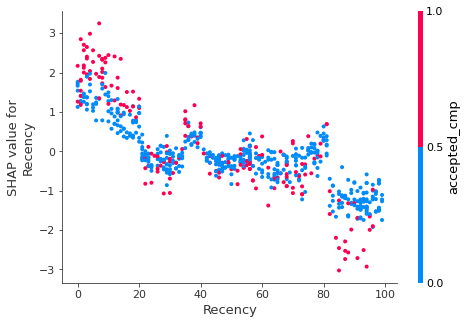

In [41]:
shap.dependence_plot("Recency", shap_values, x_test)


Recency is negatively linearly related to promotions made in campaigns.

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


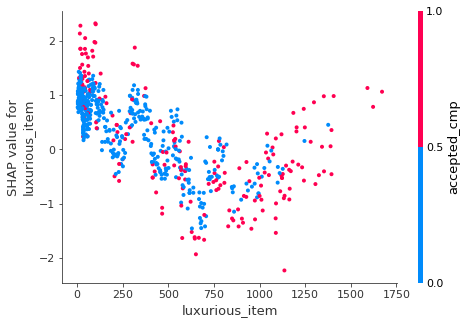

In [34]:
shap.dependence_plot("luxurious_item", shap_values, x_test)


It can be deduced by the graph that custormers spending more are more inclined towards cmp(promotion coupons).

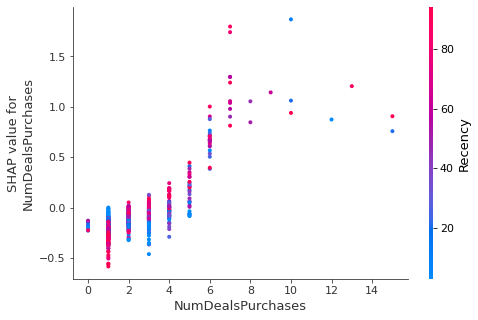

In [53]:
shap.dependence_plot("NumDealsPurchases", shap_values, x_test)

In [35]:
shap.force_plot(explainer.expected_value, shap_values, x_test)

Total 1600 datapoints are available in the x_test dataset. This graph provides mean of different features at different different no. of observations. 

One can navigate through this graph for taking glance of different features.

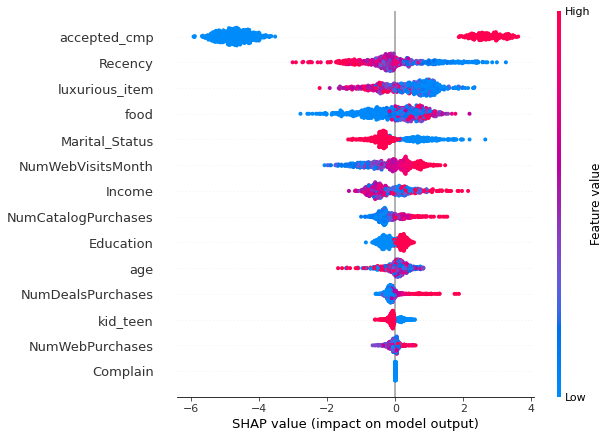

In [36]:
shap.summary_plot(shap_values, x_test)

This pictorial representation shows how features are impacting the target variable. from this we can easily deduce that accepted_cmp is highly positively related. 


luxurious_item, Recency, Marital_status has low positive relationship with the target feature.

It seems like Complain has no impact.

kid_teen, NumDealsPurchase are less important features.

There are potntial outliers present in the feautres, especially in age, Mariatal_Status, Recency.

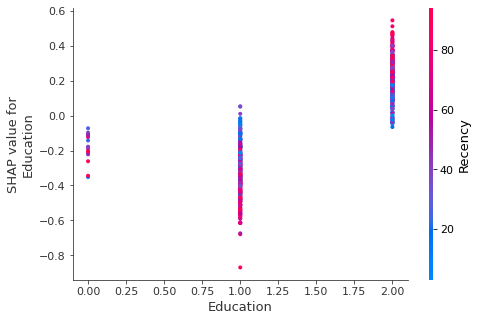

In [37]:
shap.dependence_plot("Education", shap_values, x_test)

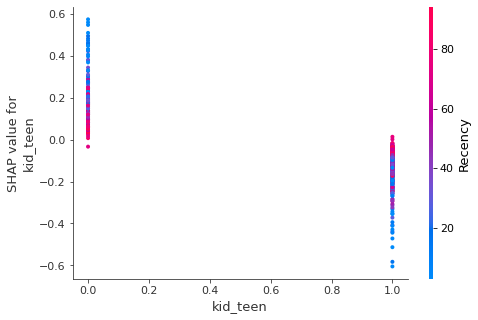

In [38]:
shap.dependence_plot("kid_teen", shap_values, x_test)

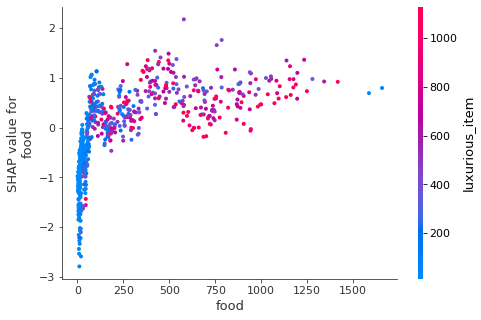

In [39]:
shap.dependence_plot("food", shap_values, x_test)

Food has positive linear relationship with luxurious_item features.

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


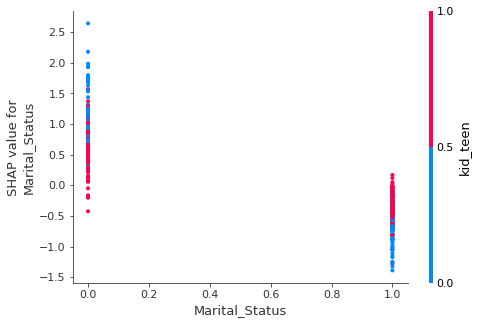

In [42]:
shap.dependence_plot("Marital_Status", shap_values, x_test)

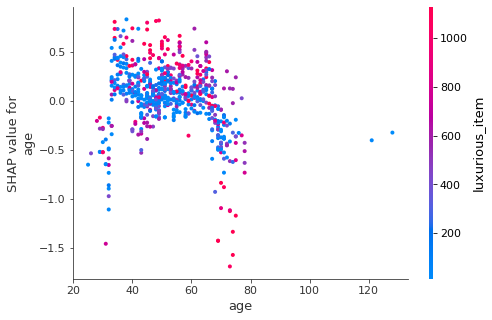

In [43]:
shap.dependence_plot("age", shap_values, x_test)

We can say here that age has negatively linearly related to luxurious_item or in other words spending on luxurious item is independent of age factor.

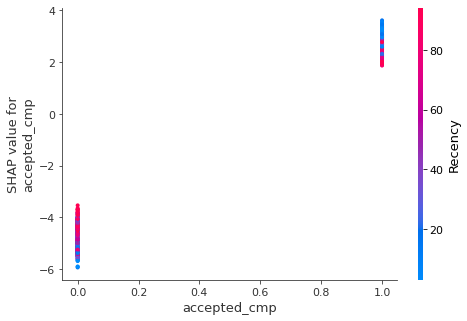

In [40]:
shap.dependence_plot("accepted_cmp", shap_values, x_test)

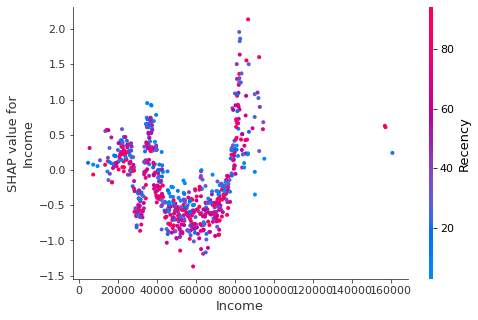

In [47]:
shap.dependence_plot("Income", shap_values, x_test)

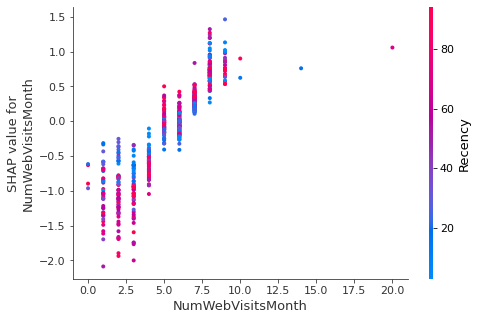

In [49]:
shap.dependence_plot("NumWebVisitsMonth", shap_values, x_test)

In [54]:
shap.force_plot(explainer.expected_value, shap_values[10,:], x_test.iloc[10,:])

In [55]:
shap.force_plot(explainer.expected_value, shap_values[25,:], x_test.iloc[25,:])

Key Take aways from analysis of this dataset are:

1.age feature has no impact on purchase of luxurious_items. Means there is equal possiblity of purchase of items like wine , gold among others by a person aged 45 and other who aged 67.

2.Recency is negatively linearly related to cmp which means person who shopped today are more likely to shop tomorrow (in nearest future) provided they get coupons/discounts.

3.Recency, luxurious_item, food, Mariatal_Status are among most important features. Company must focus on these features in desining promotions.